# Introducción
La solución propuesta consistió en entrenar un modelo de clasificación basado en BERT para predecir seis etiquetas distintas: 'urgent', 'artificial intelligence', 'computer', 'travel', 'animal' y 'fiction'. Los datos utilizados para entrenar el modelo fueron generados a partir de GPT-2.

Para replicar este proceso, no es indispensable volver a ejecutar GPT-2, ya que el archivo gpt2_database_4k.parquet ya contiene la base de datos generada, con 4,000 ejemplos por clase. Si aún se desea generar nuevos datos, se puede ejecutar el notebook generate_data, que emplea GPT-2 para crear la base de datos.

Este notebook se probó entrenar el modelo completo sin congelar pesos.

In [1]:
import pandas as pd
from datasets import Dataset, ClassLabel
from transformers import BertTokenizer
from datasets import DatasetDict
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, EarlyStoppingCallback
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
# Verificar si hay una GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Carga y preparación de datos

In [3]:
# Cargar el archivo Parquet generado previamente
df = pd.read_parquet("gpt2_database_4k.parquet")  
df

,text,label
0,"What are the first two sentences?\n\n""In the m...",urgent
1,"To read it aloud, try to figure out what the r...",urgent
2,It will do well in class.\n\nAnd there are a c...,urgent
3,"Or if you want to send a word, simply type the...",urgent
4,The last two steps here might be pretty obviou...,urgent
...,...,...
23995,A sentence from a novel can either be classifi...,fiction
23996,A good story to write a story about when you a...,fiction
23997,A sentence containing either a quotation marks...,fiction
23998,This means that you need to make sure that the...,fiction


In [4]:
# Verificamos cantidad de labels
df["label"].value_counts()

label
urgent                     4000
artificial intelligence    4000
computer                   4000
travel                     4000
animal                     4000
fiction                    4000
Name: count, dtype: int64

In [5]:
# mapeando categorias a números
categories = ['urgent', 'artificial intelligence', 'computer', 'travel', 'animal', 'fiction']
label_mapping = { k: i for i,k in enumerate(categories)}
print(label_mapping)

{'urgent': 0, 'artificial intelligence': 1, 'computer': 2, 'travel': 3, 'animal': 4, 'fiction': 5}


In [6]:
# Submuestrear (undersample) para cada categoría, limitando a un máximo de n registros por categoría
max_records = 4000

# Realizamos el submuestreo por categoría utilizando groupby y apply
df_filtered = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(max_records, len(x)), random_state=42)  # Aquí se asegura la reproducibilidad
).reset_index(drop=True)

/tmp/ipykernel_1260075/3943158983.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df.groupby('label', group_keys=False).apply(


In [7]:
# Verificamos cantidad de labels en caso de muestreo
df_filtered["label"].value_counts()

label
animal                     4000
artificial intelligence    4000
computer                   4000
fiction                    4000
travel                     4000
urgent                     4000
Name: count, dtype: int64

In [8]:
# Asignamos la etiqueta numérica correspondiente
df_filtered['labels'] = df_filtered['label'].map(label_mapping)

# Verifica que las columnas necesarias estén bien formateadas
display(df_filtered[['text', 'labels']])

,text,labels
0,"In the end, you'll be able to find a lot of in...",4
1,You can now specify the number of animals you ...,4
2,"Take a word that could mean something like ""I ...",4
3,"For example, I like using this to mean 'animal...",4
4,The term is useful in cases where you have thr...,4
...,...,...
23995,"""I've been in trouble with authorities for the...",0
23996,Write a story with that sort of thoughtfulness...,0
23997,"Do I need to get a response? No, thank you. I ...",0
23998,But I know you will look for it. Because we bo...,0


In [9]:
# Convertimos el dataframe a un dataset de Hugging Face
dataset = Dataset.from_pandas(df_filtered[['text', 'labels']])
dataset = dataset.cast_column('labels', ClassLabel(num_classes=len(categories), names=categories))

# Tokenización usando BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Usamos el método `train_test_split` de Hugging Face que funciona con su Dataset.
train_dataset, valid_dataset = tokenized_datasets.train_test_split(test_size=0.2, stratify_by_column="labels",  seed=42).values()

# Verificamos las dimensiones de los datasets resultantes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")


Casting the dataset:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Training dataset size: 19200
Validation dataset size: 4800


## Creación del modelo con BERT para fine-tuning

In [10]:
# Cargar el modelo de BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(categories), hidden_dropout_prob=0.3)  
model = model.to(device)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 109486854


In [11]:
# computar las siguientes metricas cada epoca
def compute_metrics(p):
    # Extraer las predicciones y etiquetas verdaderas
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)  # Obtener las clases predichas
    
    # Calcular las métricas de interés
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')  # F1 score ponderado
    recall = recall_score(labels, predictions, average='weighted')  # Recall ponderado
    precision = precision_score(labels, predictions, average='weighted')  # Precision ponderada

    return {
        'accuracy': accuracy,
        'f1': f1,
        'recall': recall,
        'precision': precision
    }

In [12]:
# Configuración de cada cuantos pasos hacer un logging
batch_size = 3

# Configurar los parámetros de entrenamiento
training_args = TrainingArguments(
    #learning_rate = 0.01,
    output_dir="./results_bert",         # Carpeta donde se guardarán los resultados
    num_train_epochs=3,                  # Número de épocas
    per_device_train_batch_size=batch_size,       # Tamaño del batch para el entrenamiento
    per_device_eval_batch_size=batch_size,        # Tamaño del batch para la validación
    warmup_steps=500,                    # Pasos de calentamiento para el optimizador
    weight_decay=0.01,                   # Decaimiento del peso para evitar sobreajuste
    logging_dir="./logs_bert",           # Carpeta para los logs
    evaluation_strategy="epoch",         # Evaluación cada ciertos pasos
    save_strategy="epoch",               # Guardar el modelo al final de cada época
    save_total_limit=2,                  # Mantener solo los 2 checkpoints más recientes
    load_best_model_at_end=True,           # Cargar el mejor modelo al final del entrenamiento
    metric_for_best_model="eval_loss",     # Métrica para comparar cuál es el mejor modelo (usamos el loss)
    greater_is_better=False,               # Dado que un valor de loss más bajo es mejor
    #fp16=True                        # Habilitar precisión mixta (mixed precision)
)

/home/acer-2050/.cache/pypoetry/virtualenvs/desafio1-HzSGX0Xq-py3.10/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# Crear el objeto Trainer
trainer = Trainer(
    model=model,                         # El modelo preentrenado
    args=training_args,                  # Los argumentos de entrenamiento
    train_dataset=train_dataset,         # El dataset de entrenamiento
    eval_dataset=valid_dataset,          # El dataset de validación
    compute_metrics=compute_metrics,     # Función de métricas
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

## Entrenamiento del modelo (fine-tuning)

In [14]:
# Entrenar el modelo 
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.960700,0.917560,0.731250,0.730575,0.731250,0.744265
2,0.745600,0.969809,0.756250,0.756598,0.756250,0.761607
3,0.692500,1.065026,0.761667,0.761858,0.761667,0.763905


TrainOutput(global_step=19200, training_loss=0.8290276209513346, metrics={'train_runtime': 9951.1173, 'train_samples_per_second': 5.788, 'train_steps_per_second': 1.929, 'total_flos': 1.51557410783232e+16, 'train_loss': 0.8290276209513346, 'epoch': 3.0})

In [15]:
# Guardar el modelo y el tokenizador
model.save_pretrained("./bert_model")
tokenizer.save_pretrained("./bert_model")

('./bert_model/tokenizer_config.json',
 './bert_model/special_tokens_map.json',
 './bert_model/vocab.txt',
 './bert_model/added_tokens.json')

## Resultados y evaluaciones

In [16]:
# Evaluar el modelo en el conjunto de validación
trainer.evaluate()

{'eval_loss': 0.9175595045089722,
 'eval_accuracy': 0.73125,
 'eval_f1': 0.7305753463069088,
 'eval_recall': 0.73125,
 'eval_precision': 0.7442647944668324,
 'eval_runtime': 224.4898,
 'eval_samples_per_second': 21.382,
 'eval_steps_per_second': 7.127,
 'epoch': 3.0}

In [17]:
import torch.nn.functional as F

def predict(text):
    # Tokenizar y mover los datos a la misma ubicación del modelo
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Mover los tensores al dispositivo
    
    # Realizar la predicción
    with torch.no_grad():  # Desactivar el cálculo de gradientes (no es necesario para la inferencia)
        outputs = model(**inputs)
    
    logits = outputs.logits
    
    # Aplicar softmax a los logits para obtener probabilidades
    probabilities = F.softmax(logits, dim=-1)
    
    # Obtener la clase con la mayor probabilidad
    predicted_class_id = torch.argmax(probabilities, dim=-1).item()  # Clase con la mayor probabilidad
    
    # Devolver la clase predicha y las probabilidades de cada clase
    return predicted_class_id, probabilities.squeeze().cpu().numpy()  # `squeeze()` elimina dimensiones innecesarias

def predict_text(text):
    prediction, proba = predict(text)
    print(f"Predicción: {categories[prediction]}")
    print(f"Probabilidad: {proba[prediction]}")
    print(f"Lista de probabilidades {proba}")



### Resultados del problema

In [18]:
predict_text("The axolotl is more than a peculiar amphibian; in its natural environment, it plays an essential role in the ecological stability of the Xochimilco canals.")

Predicción: animal
Probabilidad: 0.9821435809135437
Lista de probabilidades [4.0735240e-04 8.9786220e-03 2.1467058e-03 1.0351904e-03 9.8214358e-01
 5.2886349e-03]


In [19]:
predict_text("Geoffrey Hinton, Yann LeCun and Yoshua Bengio are considered the ‘godfathers’ of an essential technique in artificial intelligence, called ‘deep learning’.")

Predicción: artificial intelligence
Probabilidad: 0.9965954422950745
Lista de probabilidades [9.2174753e-04 9.9659544e-01 1.2482856e-03 2.8038095e-04 3.2285714e-04
 6.3130190e-04]


In [20]:
predict_text("Greenland is about to open up to adventure-seeking visitors. How many tourists will come is yet to be seen, but the three new airports will bring profound change.")

Predicción: travel
Probabilidad: 0.9975747466087341
Lista de probabilidades [8.0824207e-04 3.0681078e-04 3.5343086e-04 9.9757475e-01 5.4874818e-04
 4.0797380e-04]


In [21]:
predict_text("GitHub Copilot is an AI coding assistant that helps you write code faster and with less effort, allowing you to focus more energy on problem solving and collaboration.")

Predicción: artificial intelligence
Probabilidad: 0.9963905215263367
Lista de probabilidades [8.5040397e-04 9.9639052e-01 1.5637341e-03 3.1349662e-04 3.0212948e-04
 5.7972828e-04]


In [22]:
predict_text("I have a problem with my laptop that needs to be resolved asap!!")

Predicción: urgent
Probabilidad: 0.9908273816108704
Lista de probabilidades [9.9082738e-01 2.5774857e-03 1.2317710e-03 1.7971447e-03 6.9262617e-04
 2.8735853e-03]


### Evaluación de resultados

In [23]:

# Función para calcular las métricas globales
def compute_global_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')  # 'weighted' para ponderar las clases
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Función para calcular las métricas por clase
def compute_class_metrics(predictions, labels):
    precision_per_class = precision_score(labels, predictions, average=None)  # Metrica por clase
    recall_per_class = recall_score(labels, predictions, average=None)
    f1_per_class = f1_score(labels, predictions, average=None)

    # Convertir los arreglos de métricas por clase en listas
    precision_per_class = precision_per_class.tolist()
    recall_per_class = recall_per_class.tolist()
    f1_per_class = f1_per_class.tolist()

    return {
        'class':categories,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }

In [24]:
# Realizar predicciones sobre el conjunto de validación
predictions = trainer.predict(valid_dataset)

# Obtener las predicciones y las etiquetas verdaderas
pred_labels = np.argmax(predictions.predictions, axis=-1)  # Obtener las clases predichas
true_labels = predictions.label_ids  # Obtener las clases verdaderas

# Aplicar softmax a los logits para obtener probabilidades
pred_probas = F.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

In [25]:
# Imprimir las primeras 10 predicciones y sus verdaderas etiquetas
print(f"Predicciones: {pred_labels[:10]}")
print(f"Etiquetas verdaderas: {true_labels[:10]}")
print(f"Probabilidades: {pred_probas[:10]}")

Predicciones: [3 4 2 3 0 4 3 1 1 0]
Etiquetas verdaderas: [0 4 2 5 0 4 3 1 1 0]
Probabilidades: [[2.70346329e-02 4.19142842e-02 2.57219553e-01 4.34496254e-01
  2.02621341e-01 3.67139801e-02]
 [8.72521568e-03 4.27861661e-02 1.45775052e-02 5.28298877e-02
  7.60715902e-01 1.20365314e-01]
 [2.18074070e-04 2.53645563e-03 9.94538724e-01 1.58550404e-03
  7.88121310e-04 3.33085656e-04]
 [6.46720827e-02 7.11756498e-02 1.31862819e-01 2.99815744e-01
  1.52298883e-01 2.80174792e-01]
 [9.92144465e-01 2.01867707e-03 1.09511474e-03 1.68278941e-03
  5.64780028e-04 2.49422109e-03]
 [8.77643033e-05 5.51778823e-04 2.02489246e-04 1.45985017e-04
  9.98626590e-01 3.85421969e-04]
 [7.07354629e-04 3.02334665e-04 3.82329017e-04 9.97687459e-01
  5.64098067e-04 3.56389879e-04]
 [4.46363632e-03 7.44917750e-01 1.90050468e-01 2.83391140e-02
  2.04873923e-02 1.17416196e-02]
 [1.11873839e-02 7.04537630e-01 1.29484639e-01 4.99844588e-02
  6.96410015e-02 3.51648331e-02]
 [9.89671707e-01 2.79902504e-03 1.22957374e-03 2.

### Accuracy, precision, recall y f1

In [26]:
#Obteniendo metricas globales y por clase
pd.DataFrame(compute_class_metrics(pred_labels, true_labels ))

,class,precision_per_class,recall_per_class,f1_per_class
0,urgent,0.720730,0.83875,0.775274
1,artificial intelligence,0.826019,0.65875,0.732962
2,computer,0.625819,0.83625,0.715891
3,travel,0.703971,0.73125,0.717351
4,animal,0.800000,0.71000,0.752318
5,fiction,0.789050,0.61250,0.689655


In [27]:
compute_global_metrics(pred_labels, true_labels )

{'accuracy': 0.73125,
 'precision': 0.7442647944668324,
 'recall': 0.73125,
 'f1': 0.7305753463069088}

### Matriz de confusión

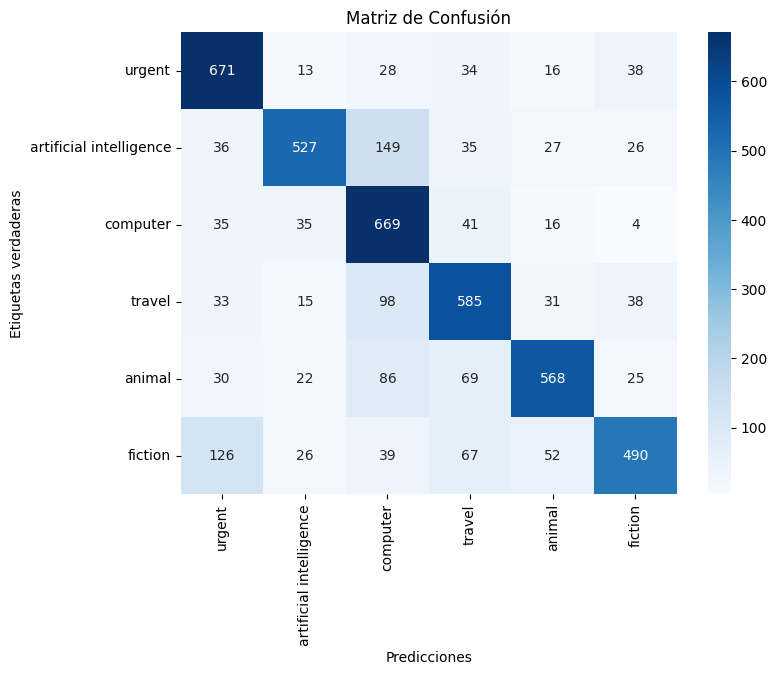

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns 
# Calcular la matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)
# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas verdaderas")
plt.show()

### Curva ROC

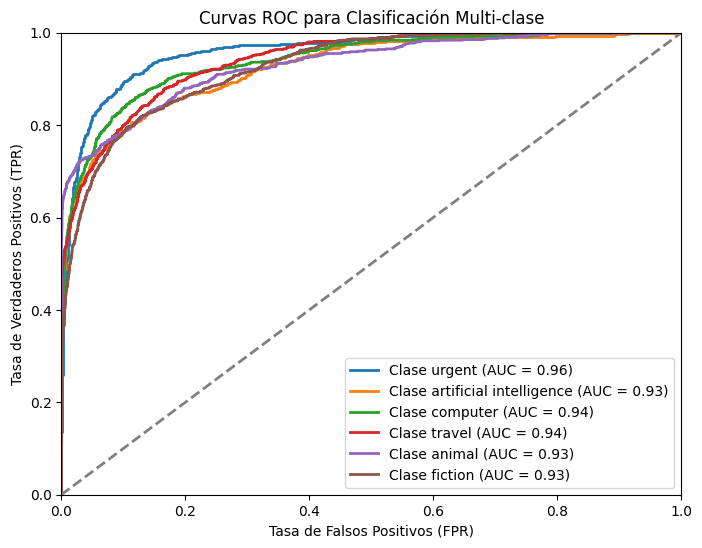

In [31]:
# Inicializar la figura para la curva ROC
plt.figure(figsize=(8, 6))
n_classes = len(categories)

# Calcular la curva ROC para cada clase
for i in range(n_classes):
    if np.sum(true_labels == i) == 0:  # Si no hay ejemplos positivos para esta clase, la omitimos
        print(f"No hay ejemplos positivos para la clase {i}")
        continue

    # Calcular la curva ROC para la clase i
    fpr, tpr, thresholds = roc_curve(true_labels == i, pred_probas[:, i])  # Probabilidades de la clase i
    roc_auc = auc(fpr, tpr)  # Calcular el AUC

    # Graficar la curva ROC
    plt.plot(fpr, tpr, lw=2, label=f'Clase {categories[i]} (AUC = {roc_auc:.2f})')

# Graficar la línea diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Añadir etiquetas y leyenda
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para Clasificación Multi-clase')
plt.legend(loc="lower right")

# Mostrar la gráfica de las curvas ROC
plt.show()